In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from utils import *
from visual_tool import *


parser = argparse.ArgumentParser()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Prepare Dataset

In [4]:
partition = make_partition(50000, 0.1, 0.1, 123)

# 2. Model Architecture

Create char_to_ix Ref: https://github.com/pytorch/tutorials/blob/master/beginner_source/nlp/word_embeddings_tutorial.py  
Pre-defined Embedding Layer Ref: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  
ResNet Variation Ref: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

# 3. Train, Validate, Evaluate

In [5]:
def train(model, partition, optimizer, criterion, args, **kwargs):
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()

        model.train()
        optimizer.zero_grad()
        pred_y = model(X, A)
#         pred_y.require_grad = False
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
        args.bar.update(len(X))
    return model, list_train_loss

def validate(model, partition, criterion, args):
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.test_batch_size,
        shuffle=args.shuffle
    )
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X, A)
        pred_y.require_grad = False
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, partition, args, **kwargs):
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.test_batch_size,
        shuffle=False
    )
    
    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X, A)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()
        args.bar.update(len(X))

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()
    args.vocab_size = 40
    args.max_len = 50
    model = Net(args)
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition, optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition, criterion, args)
        mae, std, true_y, pred_y = test(model, partition, args, **{'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

In [6]:
class GConv(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GConv, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, X, A):
        x = self.fc(X)
        x = torch.matmul(A, x)
        return x, A
    
class BN1d(nn.Module):
    def __init__(self, out_dim, use_bn):
        super(BN1d, self).__init__()
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):
        if not self.use_bn:
            return  x
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x
        
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn, dp_rate, sc_type):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.sc_type = sc_type
        self.gconv = GConv(in_dim, out_dim)
        self.bn1 = BN1d(out_dim, use_bn)
        self.dropout = nn.Dropout2d(dp_rate)
        self.relu = nn.ReLU()
        
        if not self.sc_type in ['no', 'gsc', 'sc']:
            raise Exception

        if self.sc_type != 'no':
            self.bn2 = BN1d(out_dim, use_bn)
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut.add_module(
                    'shortcut', nn.Linear(in_dim, out_dim, bias=False)
                )
                
        if self.sc_type == 'gsc':
            self.g_fc1 = nn.Linear(out_dim, out_dim, bias=True)
            self.g_fc2 = nn.Linear(out_dim, out_dim, bias=True)
            self.sigmoid = nn.Sigmoid()

    def forward(self, _x, A):
#         print("_x : ", _x.shape, "A : ", A.shape)
        x, A = self.gconv(_x, A)
#         print("x : ", x.shape, "A : ", A.shape)


        if self.sc_type == 'no': #no skip-connection
            x = self.relu(self.bn1(x))
            return self.dropout(x), A
        
        elif self.sc_type == 'sc': # basic skip-connection
            x = self.relu(self.bn1(x))
            x = x + self.shortcut(_x)          
            return self.dropout(self.relu(self.bn2(x))), A
        
        elif self.sc_type == 'gsc': # gated skip-connection
            x = self.relu(self.bn1(x)) 
            x1 = self.g_fc1(self.shortcut(_x))
            x2 = self.g_fc2(x)
            gate_coef = self.sigmoid(x1+x2)
            x = torch.mul(x1, gate_coef) + torch.mul(x2, 1.0-gate_coef)
            return self.dropout(self.relu(self.bn2(x))), A
             
            

class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()   
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train)
        
        # Create Residual Convolution layer
        list_gconvs = list()
        
        hidden_dim = args.hidden_dim1
        for i in range(args.n_stage):
            if i==0:
                list_gconvs.append(ResBlock(58, hidden_dim, args.use_bn, args.dp_rate, args.sc_type))
            else:
                list_gconvs.append(ResBlock(hidden_dim, hidden_dim*2, args.use_bn, args.dp_rate, args.sc_type))
                hidden_dim *= 2
            for j in range(args.n_layer-1):
                list_gconvs.append(ResBlock(hidden_dim, hidden_dim, args.use_bn, args.dp_rate, args.sc_type))

        self.gconvs = list_gconvs
        for module in self.gconvs:
            module.to(args.device)
        
        # Create MLP layers for regression
        self.fc_readout = nn.Linear(hidden_dim, args.hidden_dim2)
        self.fc1 = nn.Linear(args.hidden_dim2, args.hidden_dim2)
        self.fc2 = nn.Linear(args.hidden_dim2, args.hidden_dim2//2)
        self.fc3 = nn.Linear(args.hidden_dim2//2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    

    def forward(self, x, A):
        A = A.float()
        x = self._embed(x)          # embedding layer
        x, _ = self._encode(x, A)   # encoding through gcn layer
        x = self.sigmoid(torch.sum(self.fc_readout(x), dim=1))     # readout layer 
        x = self.relu(self.fc1(x))                # regressor MLP
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)
          
    def _embed(self, x):
        embed_x = self.embedding(x[:,:,0])
        x = torch.cat((embed_x, x[:,:,1:].float()), 2)
        return x 
    
    def _encode(self, x, A):
        for i, module in enumerate(self.gconvs):
            x, A = module(x, A)
        return x, A

    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# Experiment.1  lr vs l2_coef

In [8]:
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp1_n_layer_n_stage'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 1
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.sc_type = 'no'
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 100
args.batch_size= 2048
args.test_batch_size= 2048
args.emb_train = False
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
list_var1 = [1, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [1,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for var1 in list_var1:
    for var2 in list_var2:
        ts = time.time()
        # Update hyperparameter
#         args.lr = var1
        args.n_layer = var1
        args.n_stage = var2
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))

In [33]:
exp_name = 'exp1_n_layer_n_stage'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 1
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.sc_type = 'no'
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 100
args.batch_size= 2048
args.test_batch_size= 2048
args.emb_train = False
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

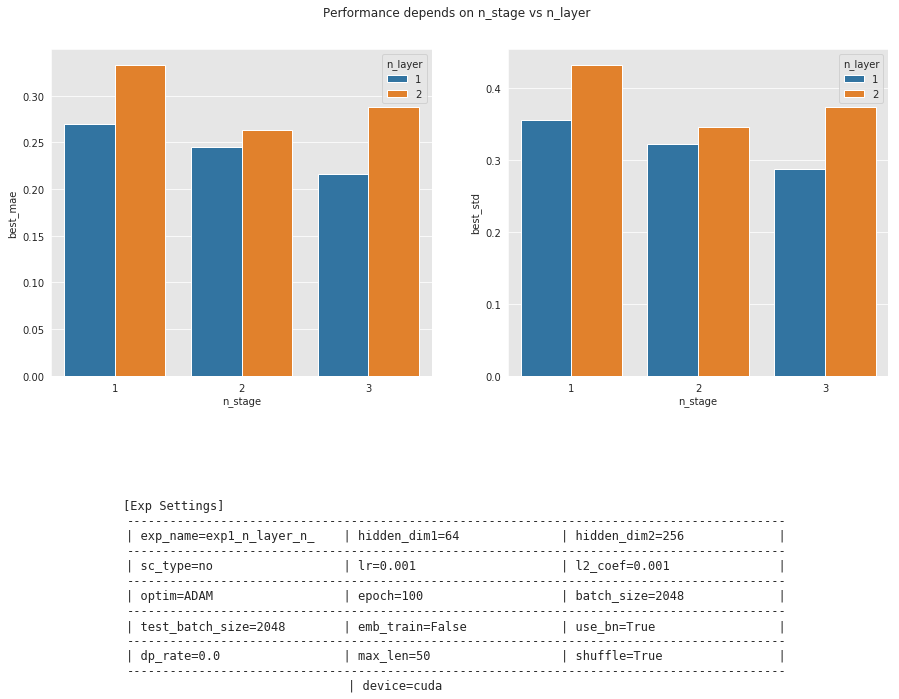

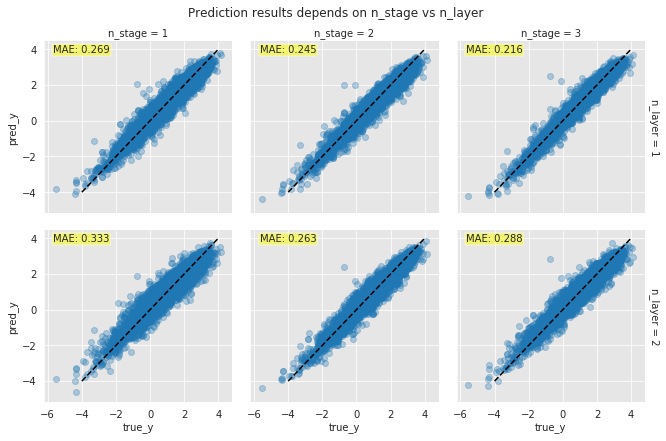

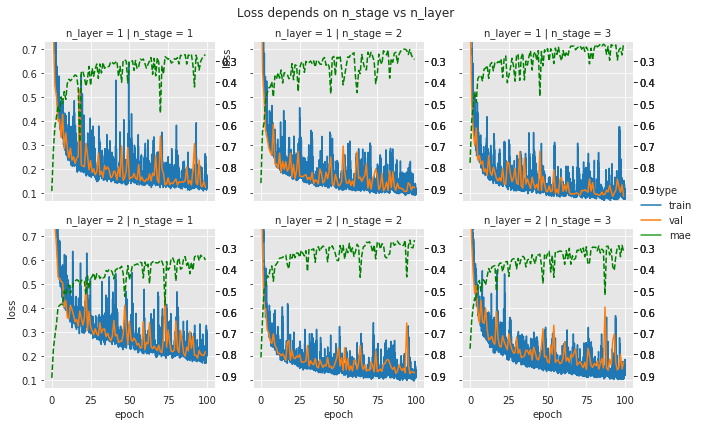

In [35]:
results = writer.read(exp_name='exp1_n_layer_n_stage')

variable2 = 'n_layer'
variable1 = 'n_stage'


plot_performance(results, variable1, variable2, args,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.1 n_stage vs n_layer  

In this experiment, regression performance was measured by 'mae' metric among the variation of the number of the residual block(n_stage) and the number of the layer per block(n_layer).  

**Variable Domain**  
- n_stage = [1, 2, 3, 4]  
- n_layer = [1, 2, 3, 4]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of residual block and number of convolution layer in the residual block. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the residual block increased, overall performance was increased.  
- As the number of the layer in a residual block increased, overall performance was decreased.  
- Therefore, 4 block with 1 layer per block achieved highest performance. 

**Discussion**  
- I expected that 4 block with 4 layer per block would outperform other models, however it was not. This results should be reconsidered since the loss chart of 4 block with 4 layer per block shows that the validation loss is still lower than the train loss. Therefore, longer training should be conducted. 
- As expected, the models with less residual block shows poor prediction performance. 

# Experiment.2 Block Type vs Batch Normalization

In [14]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp2_skipconnection_n_stage'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 1
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.sc_type = 'no'
args.lr = 0.003
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 100
args.batch_size= 2048
args.test_batch_size= 2048
args.emb_train = False
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
list_var1 = [1, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = ['no', 'sc', 'gsc'] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for var1 in list_var1:
    for var2 in list_var2:
        ts = time.time()
        # Update hyperparameter
#         args.lr = var1
        args.sc_type = var2
        args.n_stage = var1
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))

[Exp  1] got mae: 0.274, std: 0.361 at epoch 100 took 131.2sec
[Exp  2] got mae: 0.252, std: 0.334 at epoch 100 took 146.4sec
[Exp  3] got mae: 0.323, std: 0.419 at epoch 100 took 156.8sec
[Exp  4] got mae: 0.230, std: 0.306 at epoch 100 took 152.5sec
[Exp  5] got mae: 0.213, std: 0.283 at epoch 100 took 243.6sec
[Exp  6] got mae: 0.324, std: 0.422 at epoch 100 took 277.9sec
[Exp  7] got mae: 0.250, std: 0.334 at epoch 100 took 209.8sec
[Exp  8] got mae: 0.231, std: 0.307 at epoch 100 took 356.5sec
[Exp  9] got mae: 0.287, std: 0.381 at epoch 100 took 436.7sec
[Exp 10] got mae: 0.265, std: 0.351 at epoch 100 took 295.5sec
[Exp 11] got mae: 0.268, std: 0.355 at epoch 100 took 518.3sec
[Exp 12] got mae: 0.324, std: 0.428 at epoch 100 took 715.9sec


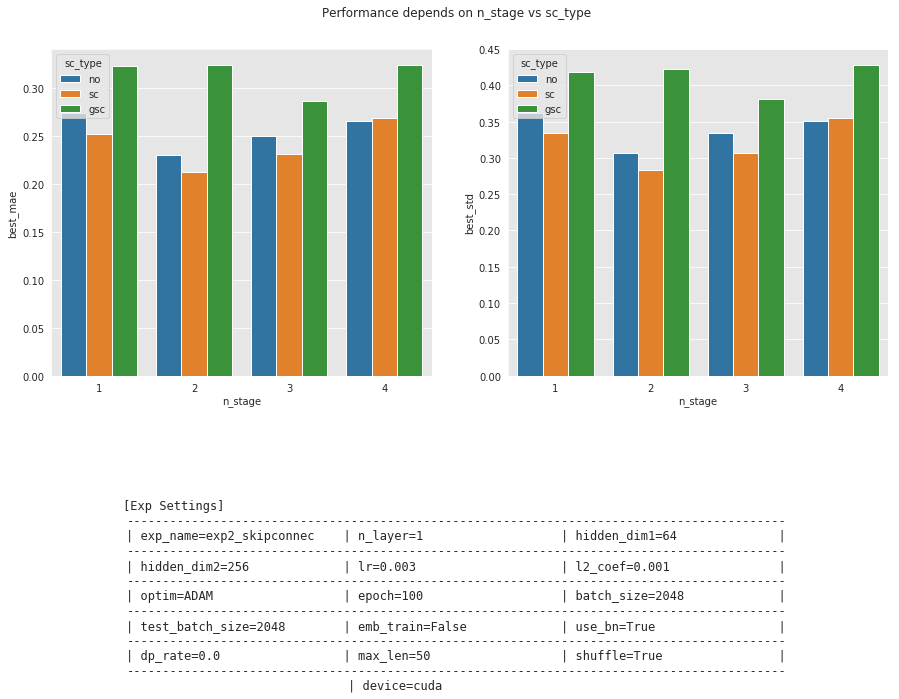

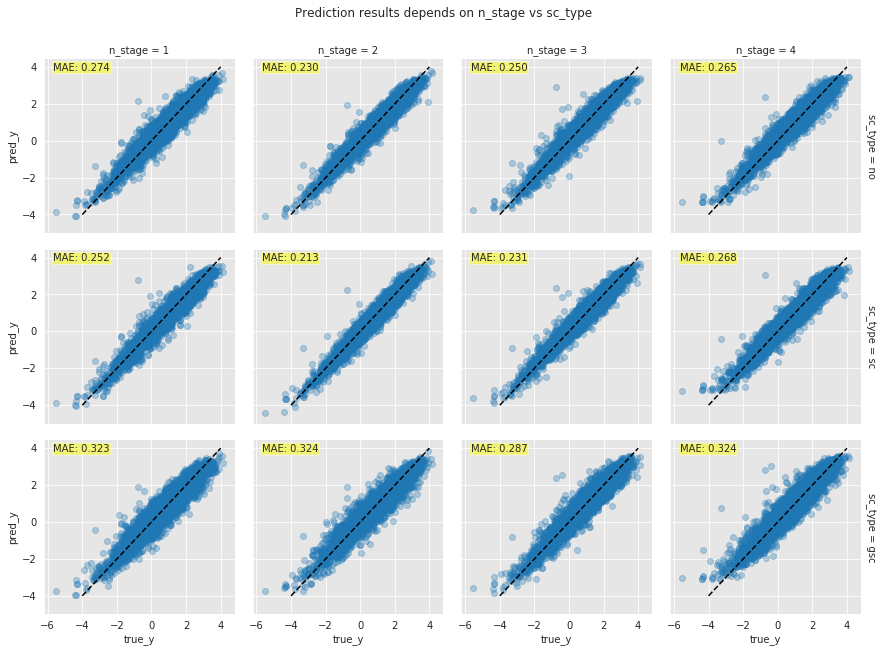

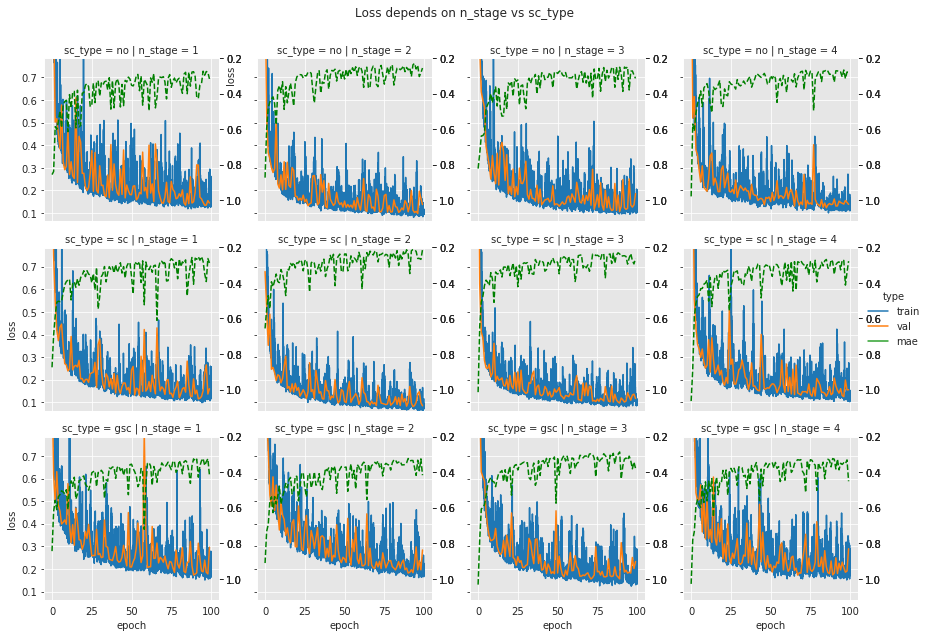

In [37]:
results = writer.read(exp_name='exp2_skipconnection_n_stage')

variable1 = 'n_stage'
variable2 = 'sc_type'


plot_performance(results, variable1, variable2, args,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp2_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.2 Block Type vs Batch Normalization

In this experiment, regression performance was measured by 'mae' metric among the variation of the type of the residual block(block_type) and the usage of the batch normalization layer in each residual block(use_bn).     

**Variable Domain**  
- block_type = ['a':'original, 'b':BN after addition, 'c':ReLU before addition, 'd':ReLU-only pre-activation]  
- use_bn = [True, False]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the residual block type and the usage of the batch normalization layer. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- Among 4 types of residual block, block A and C types are outperformed.
- When the batch normalization layer is used, the mae was almost reduced as half. 
- Also, when the batch normalization is applied, the mae values recorded less variation among different block types.

**Discussion**  
- The batch normalization layer boosts up the performance more than I expected. (very powerful).  
- Different residual block has less significant impact on the results.  

# Experiment.3 Trainable Embedding vs Start Channel

In [ ]:
exp_name = 'exp3_emb_train_start_channel'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 4
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 256
args.test_batch_size= 256
args.start_channel = 8
args.stride = 2
args.dp_rate = 0.3
args.max_len= 120
args.shuffle = True
args.use_bn = True
args.block_type = 'a'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'start_channel'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_emb_train = [True, False]
list_start_channel = [4,8,16,32]


# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_emb_train)*len(list_start_channel)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for emb_train in list_emb_train:
    for start_channel in list_start_channel:
        # Update hyperparameter
        args.emb_train = emb_train
        args.start_channel = start_channel
        args.bar = bar
        
        ts = time.time()
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()
        
        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} Took {:3.1f}'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))


In [ ]:
results = writer.read(exp_name='exp3_emb_train_start_channel')
# results = results.loc[results['epoch']==50]

variable1 = 'start_channel'
variable2 = 'emb_train'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.3 Trainable Embedding vs Start Channel

In this experiment, regression performance was measured by 'mae' metric among the number of the starting convolution filters(start_channel) and the usage of trainable atom embedding(emb_train).  

**Variable Domain**  
- emb_train = [True, False]
- start_channel = [4,8,16,32,64]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of convolution channel of the first residual block(start_channel) and the trainability of the atom embedding vector(emb_train). Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the start channel increased, the performance drastically improved. 
- When the embedding vectors were trained, the performance was slightly increased. 

**Discussion**  
- Increasing the number of the convolution filter results in the increasing performance. However lots of computation power required.     
- Training original embedding vector is meaningful to increase the performance. 

In [ ]:
exp_name = 'exp4_lr_l2'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 4
args.emb_train = True
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 512
args.test_batch_size= 512
args.start_channel = 16
args.stride = 2
args.dp_rate = 0.3
args.max_len= 120
args.shuffle = True
args.use_bn = True
args.block_type = 'a'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'start_channel'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_lr = [0.00005, 0.0005, 0.005, 0.05]
list_l2_coef = [0.0001, 0.001, 0.01, 0.1]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_lr)*len(list_l2_coef)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for lr in list_lr:
    for l2_coef in list_l2_coef:
        # Update hyperparameter
        args.lr = lr
        args.l2_coef = l2_coef
        args.bar = bar
        
        ts = time.time()
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()
        
        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} Took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
